In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
from pathlib import Path
from collections import Counter
import json
import nltk
import requests
from datetime import datetime, timedelta, tzinfo


nltk.download("punkt")
nltk.download("stopwords")
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

tf_idf = TfidfVectorizer(stop_words="english")


def encode_topics(df):
    # topics = df["topics"].str.get_dummies(sep=",")
    # topics = df["topics"].apply( topicfor topic in topics  )
    one_hot_encoded = (
        pd.get_dummies(df["topics"].apply(pd.Series).stack()).groupby(level=0).sum()
    )
    df = pd.concat([df, one_hot_encoded], axis=1)
    # print(df)
    return df


def set_index(df, index_column="poll_ID"):
    df.set_index(index_column, inplace=True)
    return df


def reset_index(df):
    df.reset_index()
    return df


def check_column_type(df, column_name, check_type):
    column_index = df.columns.get_loc(column_name)
    for i in range(len(df)):
        if not isinstance(df.iloc[i, column_index], check_type):
            print(
                f"error: {df.iloc[i, 0], df.iloc[i, 1],df.iloc[i, 2], df.iloc[i, 3], df.iloc[i, 4]}"
            )


def preprocess_text(text):
    tokens = nltk.tokenize.word_tokenize(text)
    # tokens = [word.lower() for word in tokens if type(word) is str]
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word not in string.punctuation]
    stop_words = set(nltk.corpus.stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    processed_text = " ".join(tokens)

    return processed_text


def preprocess_list(field_list):
    ret_list = []
    stop_words = set(nltk.corpus.stopwords.words("english"))
    for item in field_list:
        tokens = nltk.tokenize.word_tokenize(item)
        # tokens = [word.lower() for word in tokens if type(word) is str]
        tokens = [word.lower() for word in tokens]
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stop_words]
        processed_text = " ".join(tokens)
        ret_list.append(processed_text)

    return ret_list


def create_tf_idf_matrix(df, column):
    # print(f"{df[column]} is {df[column].dtype} and {df[column].dtype is list} {list}: ")
    df[column] = df[column].apply(lambda x: " ".join(x))
    df[column] = df[column].apply(preprocess_text)

    return tf_idf.fit_transform(df[column])


def create_souped_tf_idf_matrix(df):
    df["topics"] = df["topics"].apply(preprocess_list)
    df["question"] = df["question"].apply(preprocess_text)

    # Create a new soup feature
    df["soup"] = df.apply(create_soup, axis=1)

    return tf_idf.fit_transform(df["soup"])


def create_soup(df):
    res = (
        df["question"]
        + " "
        + " ".join(df["options"])
        + " "
        + (4 * (" " + " ".join(df["topics"])))
    )
    # print(f"-----------------------------------\n* Processing: [{ }]")
    return res


def calc_cosine_similarity_matrix(tf_idf_matrix_1, tf_idf_matrix_2):
    # if tf_idf_matrix_1 is not None and tf_idf_matrix_2 is not None:
    return cosine_similarity(tf_idf_matrix_1, tf_idf_matrix_2)


def id_to_index(df, search_id):
    result = df[df["id"] == str(search_id)].index.values[0]

    if len(result) > 0:
        return result
    else:
        return None


def id_to_index2(df, id):
    try:
        if any(df["id"] == str(id)):
            # df.to_csv("df.csv", index=False)
            # print(
            #    f"---------------\nFound {id} at {df[df['id'] == str(id)].index.values[0]}"
            # )
            # print(f"\nWhich is equal to:\n{df[df['id'] == str(id)]}")
            return df[df["id"] == str(id)].index.values[0]

    except IndexError as e:
        print(f"erorrrrrrrrrrrrr:")
        print(f"{str(id)}")
        print(f"{df['id']==str(id)}")


def title_from_idx(df, idx):
    return df[df.index == idx]


def gen_recommendations(
    index,
    df,
    cosine_similarity_matrix,
    number_of_recommendations,
):
    # index = idx_from_title(df, original_title)
    similarity_scores = list(enumerate(cosine_similarity_matrix[index]))
    similarity_scores_sorted = sorted(
        similarity_scores, key=lambda x: x[1], reverse=True
    )

    recommendations_indices = [
        t[0] for t in similarity_scores_sorted[1 : (number_of_recommendations + 1)]
    ]
    recommendations = list(df["title"].iloc[recommendations_indices])
    # print(recommendations)
    # print(similarity_scores_sorted, type(similarity_scores_sorted))
    # recommendations_indices = [
    #    t[0] for t in similarity_scores_sorted[1 : (number_of_recommendations + 1)]
    # ]
    # recommendations_scores = [
    #    t[1] for t in similarity_scores_sorted[1 : (number_of_recommendations + 1)]
    # ]
    # return (df["title"].iloc[recommendations_indices], recommendations_scores)

    return recommendations


def gen_rec_from_list_of_polls(
    interacted_polls,
    filtered_polls_df,
    cosine_similarity_matrix,
    number_of_recommendations,
):
    recommendations = []
    for poll_id in interacted_polls:
        index = id_to_index2(filtered_polls_df, poll_id)
        if index is not None:
            similarity_scores = list(enumerate(cosine_similarity_matrix[index]))
            similarity_scores_sorted = sorted(
                similarity_scores, key=lambda x: x[1], reverse=True
            )

            recommendations_indices = [
                t[0]
                for t in similarity_scores_sorted[1 : (number_of_recommendations + 1)]
            ]
            recs = list(filtered_polls_df["id"].iloc[recommendations_indices])

            # Filter out polls that have already been interacted with
            filtered_recs = [poll for poll in recs if poll not in interacted_polls]

            recommendations.append(filtered_recs)

        else:
            pass

        # index = id_to_index(polls, poll_id)
        # print(f"cosine_similarity_matrix:{len(cosine_similarity_matrix)}")
        # print(f"index:{index} | id:{poll_id}")

    flattened_recommendations = [
        item for sublist in recommendations for item in sublist
    ]
    flattened_recommendations = Counter(flattened_recommendations)
    n_most_recommended = flattened_recommendations.most_common(
        number_of_recommendations
    )
    n_most_recommended = [t[0] for t in n_most_recommended]
    # print(n_most_recommended)

    return n_most_recommended


def gen_rec_from_list_of_polls_df(
    interacted_polls,
    filtered_polls_df,
    cosine_similarity_matrix,
    number_of_recommendations,
):
    recommendations = []
    for poll_id in interacted_polls:
        index = id_to_index2(filtered_polls_df, poll_id)
        if index is not None:
            similarity_scores = list(enumerate(cosine_similarity_matrix[index]))
            similarity_scores_sorted = sorted(
                similarity_scores, key=lambda x: x[1], reverse=True
            )

            recommendations_indices = [
                t[0]
                for t in similarity_scores_sorted[1 : (number_of_recommendations + 1)]
            ]
            recs = list(filtered_polls_df["id"].iloc[recommendations_indices])

            # Filter out polls that have already been interacted with
            filtered_recs = [poll for poll in recs if poll not in interacted_polls]

            recommendations.append(filtered_recs)

        else:
            pass

        # index = id_to_index(polls, poll_id)
        # print(f"cosine_similarity_matrix:{len(cosine_similarity_matrix)}")
        # print(f"index:{index} | id:{poll_id}")

    flattened_recommendations = [
        item for sublist in recommendations for item in sublist
    ]
    flattened_recommendations = Counter(flattened_recommendations)
    n_most_recommended = flattened_recommendations.most_common(
        number_of_recommendations
    )
    n_most_recommended = [t[0] for t in n_most_recommended]

    filtered_df = filtered_polls_df[filtered_polls_df["id"].isin(n_most_recommended)]

    order_dict = {id: idx for idx, id in enumerate(n_most_recommended)}

    # Sort the filtered DataFrame based on the order
    # filtered_df["order"] = filtered_df["id"].map(order_dict)
    filtered_df.loc[:, "order"] = filtered_df.loc[:, "id"].map(order_dict)

    filtered_df = filtered_df.sort_values("order")

    # Drop the 'order' column if not needed
    filtered_df = filtered_df.drop(columns=["order"])

    # Reset the index if needed
    filtered_df = filtered_df.reset_index(drop=True)

    return filtered_df


def is_valid_limitations(limitations):
    if isinstance(limitations, dict):
        return (
            "allowedLocations" in limitations
            and "allowedGender" in limitations
            and "allowedAgeRange" in limitations
        )
    return False


def is_within_x_days_liifetime(timestamp):
    try:
        # Convert the timestamp to a datetime object
        time = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")

        # Calculate the time difference
        time_difference = datetime.now() - time

        return True if time_difference <= timedelta(days=10) else False
    except ValueError:
        # If the timestamp doesn't match the expected format, return False
        return False


def filter_timestamp(timestamp):
    try:
        # Convert the timestamp to a datetime object
        time = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")

        # Calculate the time difference
        time_difference = datetime.now() - time

        return time_difference
    except ValueError:
        # If the timestamp doesn't match the expected format, return None
        return None


def split_by_days(polls_df, days=10):
    filtered_df = polls_df[polls_df["createdAt"].apply(filter_timestamp).notna()]

    older_than_x_days = filtered_df[
        filtered_df["createdAt"].apply(filter_timestamp) >= timedelta(days=days)
    ]
    newer_than_x_days = filtered_df[
        filtered_df["createdAt"].apply(filter_timestamp) < timedelta(days=days)
    ]

    # Reset the index if needed
    older_than_x_days = older_than_x_days.reset_index(drop=True)
    newer_than_x_days = newer_than_x_days.reset_index(drop=True)

    return older_than_x_days, newer_than_x_days


def has_valid_date(date_str):
    # Convert the date string to a datetime object
    # date = pd.to_datetime(date_str)
    date = pd.to_datetime(date_str, utc=True).replace(tzinfo=None)

    # Get the current timestamp as a datetime object
    current_time = datetime.now()

    # Compare the date with the current timestamp
    return date > current_time


def remove_duplicates(input_list):
    seen = set()
    result = []

    for item in input_list:
        if item not in seen:
            seen.add(item)
            result.append(item)

    return result


def validate_polls_v1(polls_df, df_name, verbose=True):
    valid_polls = polls_df.loc[
        polls_df["valid"] & polls_df["endedAt"].apply(has_valid_date)
    ]

    invalid_polls = polls_df[
        ~polls_df["valid"] | ~polls_df["endedAt"].apply(has_valid_date)
    ]

    if verbose:
        print(f"valid_{df_name}_polls: {len(valid_polls)}")
        print(f"expired_{df_name}_polls: {len(invalid_polls)}")

    return valid_polls, invalid_polls
    return pd.concat([valid_polls, invalid_polls], ignore_index=False)


def validate_polls(polls_df, df_name, verbose=True):
    valid_polls = polls_df.loc[
        polls_df["valid"] & polls_df["endedAt"].apply(has_valid_date)
    ]

    invalid_polls = polls_df[~polls_df["id"].isin(valid_polls["id"].tolist())]
    # invalid_polls = polls_df.loc[
    #    ~polls_df["valid"] | ~polls_df["endedAt"].apply(has_valid_date)
    # ]

    if verbose:
        print(f"valid_{df_name}_polls: {len(valid_polls)}")
        print(f"expired_{df_name}_polls: {len(invalid_polls)}")

    return valid_polls, invalid_polls


def order_v1(
    recommended_polls_df=None,
    trend_polls_df=None,
    live_polls_flag=0,
    verbose=True,
):
    if not live_polls_flag:
        if recommended_polls_df is None:
            valid_trend_polls, invalid_trend_polls = validate_polls_v1(
                trend_polls_df, "trend", verbose
            )
            recommended_polls_df = pd.concat(
                [
                    valid_trend_polls,
                    invalid_trend_polls,
                ],
                ignore_index=False,
            )

        elif trend_polls_df is None:
            valid_recommended_polls, invalid_recommended_polls = validate_polls_v1(
                recommended_polls_df, "recommended", verbose
            )
            recommended_polls_df = pd.concat(
                [
                    valid_recommended_polls,
                    invalid_recommended_polls,
                ],
                ignore_index=False,
            )

        elif trend_polls_df is not None and recommended_polls_df is not None:
            valid_recommended_polls, invalid_recommended_polls = validate_polls_v1(
                recommended_polls_df, "recommended", verbose
            )
            valid_trend_polls, invalid_trend_polls = validate_polls_v1(
                trend_polls_df, "trend", verbose
            )

            recommended_polls_df = pd.concat(
                [
                    valid_recommended_polls,
                    valid_trend_polls,
                    invalid_recommended_polls,
                    invalid_trend_polls,
                ],
                ignore_index=False,
            )

        recommended_polls_df = recommended_polls_df.reset_index(drop=True)
        recommended_polls_df = recommended_polls_df["id"].tolist()
        recommended_polls_df = remove_duplicates(recommended_polls_df)

        return recommended_polls_df

    else:
        if recommended_polls_df is None:
            recommended_polls_df, _ = validate_polls_v1(
                trend_polls_df, "trend", verbose
            )

        elif trend_polls_df is None:
            recommended_polls_df, _ = validate_polls_v1(
                recommended_polls_df, "recommended", verbose
            )

        elif trend_polls_df is not None and recommended_polls_df is not None:
            valid_recommended_polls, invalid_recommended_polls = validate_polls_v1(
                recommended_polls_df, "recommended", verbose
            )
            valid_trend_polls, invalid_trend_polls = validate_polls_v1(
                trend_polls_df, "trend", verbose
            )

            recommended_polls_df = pd.concat(
                [
                    valid_recommended_polls,
                    valid_trend_polls,
                ],
                ignore_index=False,
            )

        recommended_polls_df = recommended_polls_df.reset_index(drop=True)
        recommended_polls_df = recommended_polls_df["id"].tolist()
        recommended_polls_df = remove_duplicates(recommended_polls_df)

        return recommended_polls_df


def order_v2(
    recommended_polls_df=None,
    trend_polls_df=None,
    live_polls_flag=False,
    verbose=True,
):
    if live_polls_flag:
        if recommended_polls_df is None:
            recommended_polls_df = validate_and_concat(trend_polls_df, "trend", verbose)

        elif trend_polls_df is not None:
            valid_recommended_polls = validate_and_concat(
                recommended_polls_df, "recommended", verbose
            )
            valid_trend_polls = validate_and_concat(trend_polls_df, "trend", verbose)

            recommended_polls_df = pd.concat(
                [valid_recommended_polls, valid_trend_polls], ignore_index=False
            )

        recommended_polls_df = recommended_polls_df.reset_index(drop=True)
        recommended_polls_df = recommended_polls_df["id"].tolist()
        recommended_polls_df = remove_duplicates(recommended_polls_df)

        return recommended_polls_df

    else:
        if recommended_polls_df is None:
            recommended_polls_df = validate_and_concat(trend_polls_df, "trend", verbose)

        elif trend_polls_df is None:
            recommended_polls_df = validate_and_concat(
                recommended_polls_df, "recommended", verbose
            )

        else:
            valid_recommended_polls = validate_and_concat(
                recommended_polls_df, "recommended", verbose
            )
            valid_trend_polls = validate_and_concat(trend_polls_df, "trend", verbose)

            recommended_polls_df = pd.concat(
                [valid_recommended_polls, valid_trend_polls], ignore_index=False
            )

        recommended_polls_df = recommended_polls_df.reset_index(drop=True)
        recommended_polls_df = recommended_polls_df["id"].tolist()
        recommended_polls_df = remove_duplicates(recommended_polls_df)

        return recommended_polls_df


def order_v3(
    recommended_polls_df=None,
    trend_polls_df=None,
    live_polls_flag=0,
    verbose=True,
):
    val_recommended_polls_df, inval_recommended_polls_df = validate_polls(
        recommended_polls_df, "recommended", verbose
    )

    val_trend_polls_df, inval_trend_polls_df = validate_polls(
        trend_polls_df, "trend", verbose
    )

    if live_polls_flag:
        recommended_polls_df = pd.concat(
            [
                val_recommended_polls_df,
                val_trend_polls_df,
            ],
            ignore_index=False,
        )
    else:
        recommended_polls_df = pd.concat(
            [
                val_recommended_polls_df,
                val_trend_polls_df,
                inval_recommended_polls_df,
                inval_trend_polls_df,
            ],
            ignore_index=False,
        )

    recommended_polls_df = recommended_polls_df.reset_index(drop=True)
    recommended_polls_df = recommended_polls_df["id"].tolist()
    recommended_polls_df = remove_duplicates(recommended_polls_df)

    return recommended_polls_df


def validate_polls_v3(polls_df, df_name, verbose=True):
    # Convert the 'timestamp_column' to a pandas datetime object
    # polls_df["liive"] = pd.to_datetime(
    #    polls_df["endedAt"], format="%Y-%m-%dT%H:%M:%S.%fZ", utc=True
    # )

    # polls_df["endedAt"] = pd.to_datetime(polls_df["endedAt"], utc=True)

    # Create a boolean mask based on whether the timestamp has passed
    # mask = (polls_df["endedAt"] < current_timestamp) & polls_df["valid"]

    # Condition 2: Check if the time in "endedAt" column has not passed
    current_timestamp = pd.Timestamp.utcnow()

    mask = (
        # (polls_df["endedAt"].notna())
        # (polls_df["liive"] < current_timestamp)
        (
            pd.to_datetime(
                polls_df["endedAt"],
                format="ISO8601",
                utc=True,
            )
            >= current_timestamp
        )
        & polls_df["valid"]
    )

    # Apply the mask to the DataFrame
    valid_polls = polls_df[mask]
    invalid_polls = polls_df[~mask]

    if verbose:
        print(f"valid_{df_name}_polls: {len(valid_polls)}")
        print(f"expired_{df_name}_polls: {len(invalid_polls)}")

    return valid_polls, invalid_polls


def order_v4(
    recommended_polls_df=None,
    trend_polls_df=None,
    live_polls_flag=0,
    verbose=True,
):
    val_recommended_polls_df, inval_recommended_polls_df = validate_polls_v3(
        recommended_polls_df, "recommended", verbose
    )

    val_trend_polls_df, inval_trend_polls_df = validate_polls_v3(
        trend_polls_df, "trend", verbose
    )

    if live_polls_flag:
        recommended_polls_df = pd.concat(
            [
                val_recommended_polls_df,
                val_trend_polls_df,
            ],
            ignore_index=True,
        )
    else:
        recommended_polls_df = pd.concat(
            [
                val_recommended_polls_df,
                val_trend_polls_df,
                inval_recommended_polls_df,
                inval_trend_polls_df,
            ],
            ignore_index=True,
        )

    recommended_polls_df = recommended_polls_df.reset_index(drop=True)
    recommended_polls_df = recommended_polls_df["id"].tolist()
    recommended_polls_df = remove_duplicates(recommended_polls_df)

    return recommended_polls_df


def order_v5(
    recommended_polls_df=None,
    trend_polls_df=None,
    live_polls_flag=0,
    verbose=True,
):
    if trend_polls_df is None:
        val_recommended_polls_df, inval_recommended_polls_df = validate_polls_v3(
            recommended_polls_df, "recommended", verbose
        )
        if live_polls_flag:
            recommended_polls_df = pd.concat(
                [
                    val_recommended_polls_df,
                ],
                ignore_index=True,
            )
        else:
            recommended_polls_df = pd.concat(
                [
                    val_recommended_polls_df,
                    inval_recommended_polls_df,
                ],
                ignore_index=True,
            )

        recommended_polls_df = recommended_polls_df.reset_index(drop=True)
        recommended_polls_df = recommended_polls_df["id"].tolist()
        recommended_polls_df = remove_duplicates(recommended_polls_df)

        return recommended_polls_df

    elif recommended_polls_df is None:
        val_trend_polls_df, inval_trend_polls_df = validate_polls_v3(
            trend_polls_df, "trend", verbose
        )
        if live_polls_flag:
            recommended_polls_df = pd.concat(
                [
                    val_trend_polls_df,
                ],
                ignore_index=True,
            )
        else:
            recommended_polls_df = pd.concat(
                [
                    val_trend_polls_df,
                    inval_trend_polls_df,
                ],
                ignore_index=True,
            )

        recommended_polls_df = recommended_polls_df.reset_index(drop=True)
        recommended_polls_df = recommended_polls_df["id"].tolist()
        recommended_polls_df = remove_duplicates(recommended_polls_df)

        return recommended_polls_df
    else:
        val_recommended_polls_df, inval_recommended_polls_df = validate_polls_v3(
            recommended_polls_df, "recommended", verbose
        )
        val_trend_polls_df, inval_trend_polls_df = validate_polls_v3(
            trend_polls_df, "trend", verbose
        )
        if live_polls_flag:
            recommended_polls_df = pd.concat(
                [
                    val_recommended_polls_df,
                    val_trend_polls_df,
                ],
                ignore_index=True,
            )
        else:
            recommended_polls_df = pd.concat(
                [
                    val_recommended_polls_df,
                    val_trend_polls_df,
                    inval_recommended_polls_df,
                    inval_trend_polls_df,
                ],
                ignore_index=True,
            )

        recommended_polls_df = recommended_polls_df.reset_index(drop=True)
        recommended_polls_df = recommended_polls_df["id"].tolist()
        recommended_polls_df = remove_duplicates(recommended_polls_df)

        return recommended_polls_df


def list_to_df(polls_list, polls_df):
    # Filter the DataFrame based on the id_list
    filtered_df = polls_df[polls_df["id"].isin(polls_list)]

    # Create a dictionary to preserve the order
    order_dict = {id: idx for idx, id in enumerate(polls_list)}

    # Sort the filtered DataFrame based on the order
    filtered_df["order"] = filtered_df["id"].map(order_dict)
    filtered_df = filtered_df.sort_values("order")

    # Drop the 'order' column if not needed
    filtered_df = filtered_df.drop(columns=["order"])

    # Reset the index if needed
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df


def filter_polls(row, user_limitations, user_id):
    print(row)
    if (
        user_id != row.get("ownerId")
        and not row.get("isDeleted")  # Check if the poll is not deleted
        and (row["pollType"] == "Public" or row["pollType"] == "PublicAnonymous")
        and isinstance(row.get("pollLimitations"), dict)
        and all(k in user_limitations for k in ["Location", "Gender", "Age"])
        # and is_within_x_days_liifetime(row["createdAt"])
    ):
        user_location = user_limitations.get("Location")

        allowed_locations = row.get("pollLimitations").get("allowedLocations")
        if len(allowed_locations) == 0 or any(
            user_location == loc for loc in allowed_locations
        ):
            allowed_gender = row["pollLimitations"]["allowedGender"]
            user_gender = user_limitations["Gender"]
            if allowed_gender == "All" or allowed_gender == user_gender:
                allowed_age_range = row["pollLimitations"]["allowedAgeRange"]
                user_age = user_limitations["Age"]
                if (
                    allowed_age_range["minimumAge"]
                    <= user_age
                    <= allowed_age_range["maximumAge"]
                ):
                    return True

    return False


def get_allowed_private_polls(
    params,
    # url="https://dev.pollett.io/api/Recommend/Polls/GetPrivatePollThatUserCanSee",
    url,
):
    # API URL
    # url = "https://dev.pollett.io/api/Recommend/Polls/GetPrivatePollThatUserCanSee"

    # Parameters
    # params = {"userId": "bbe64b34-ba34-4fbd-a62f-e6c84c0423b4"}

    # Send a GET request to the API
    response = requests.get(url, params=params)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON response
        # allowed_polls_list = response.json().get("data")
        return response.json().get("data")
        # Process the data as needed

    else:
        # Handle the error
        print(f"Request failed with status code {response.status_code}")
        print(response.text)


# if __name__ == "__main__":
#    pd.set_option("display.max_colwidth", None)
#    pd.set_option("display.max_columns", None)
#
#    path = Path(__file__).parent.parent.parent.resolve()
#    path = str(path) + "/data/elas_polls.json"
#    polls_list = []
#    # polls = pd.read_json(str(path) + "/data/elas_polls.json")
#    with open(path, "r") as infile:
#        polls = json.load(infile)
#        for poll in polls:
#            # poll = poll["_source"]
#            # print(f"poll:\n{poll}")
#            polls_list.append(poll)
#
#    polls = pd.DataFrame.from_records(polls_list)
#
#    polls = encode_topics(polls)
#    print(polls)
#    # check_column_type(polls, 4, str)
#    tf_idf_matrix = create_tf_idf_matrix(polls, "question")
#    cosine_similarity_matrix = calc_cosine_similarity_matrix(
#        tf_idf_matrix, tf_idf_matrix
#    )

[nltk_data] Downloading package punkt to /home/eyz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/eyz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from ast import Dict
from telnetlib import STATUS
from types import NoneType
from typing import Any
import redis
import os
from dotenv import load_dotenv
from sklearn.utils._param_validation import InvalidParameterError
import zlib
import base64
from pymongo import MongoClient
from io import BytesIO
from scipy.sparse import save_npz, load_npz
import pandas as pd
import time
import pickle


# from .ElasticSeachHandle.elasticsearch_handle import *


def create_redis_pool(host, port, db):
    return redis.ConnectionPool(host=host, port=port, db=db)


def create_elastic_connection(
    poller_elasticsearch_url, poller_username, poller_password, poller_fingerprint
):
    try:
        elasticsearch_url = os.environ.get(poller_elasticsearch_url)
        username = os.environ.get(poller_username)
        password = os.environ.get(poller_password)
        fingerprint = os.environ.get(poller_fingerprint)
        elastic_handle = ElasticsearchHandel(
            elasticsearch_url, username, password, fingerprint
        )
        if elasticsearch_url and username and password and fingerprint:
            print(
                "[2. Environment variables were read correctly through (enivronment variables).]"
            )
            return elastic_handle
    except ConnectionTimeout as e:
        load_dotenv()
        elasticsearch_url = os.getenv("POLLER_ELASTICSEARCH_URL")
        username = os.getenv("POLLER_USERNAME")
        password = os.getenv("POLLER_PASSWORD")
        fingerprint = os.getenv("POLLER_FINGERPRINT")

        try:
            elastic_handle = ElasticsearchHandel(
                elasticsearch_url, username, password, fingerprint
            )
            if elasticsearch_url and username and password and fingerprint:
                print(
                    "[2. Environment variables were read correctly through (getenv).]"
                )
            return elastic_handle
        except TypeError:
            print("[2. Failed to read environment variables.]")
            print(e)


def remove_duplicates(input_list):
    seen = set()
    result = []

    for item in input_list:
        if item not in seen:
            seen.add(item)
            result.append(item)

    return result


def get_entity(redis_client, entity_key, extend_expiration=600):
    # Get the entity from Redis
    entity = redis_client.get(entity_key)

    # If the entity exists, reset the expiration time (e.g., to 60 seconds)

    if entity:
        redis_client.expire(entity_key, extend_expiration)
        # print(f"The data for {entity_key} exists in Redis.")
        return entity


def find_duplicates(lst):
    seen = set()
    duplicates = set()
    for item in lst:
        if item in seen:
            duplicates.add(item)
        else:
            seen.add(item)
    return duplicates


def insert_item_to_mongodb(
    polls_tf_idf_matrix,
    collection,
    user_id,
    polls_df,
    filtered_trend_polls_list,
):
    # Save the sparse matrix to a BytesIO buffer
    buffer = BytesIO()

    save_npz(buffer, polls_tf_idf_matrix)

    # Reset the buffer position to the beginning
    buffer.seek(0)

    # Read the buffer content into binary data

    binary_data = buffer.read()

    # Compress the binary data

    compressed_data = zlib.compress(binary_data)

    # Encode the compressed data as base64 for BSON storage

    encoded_data = base64.b64encode(compressed_data).decode("utf-8")

    polls_dict = polls_df.to_dict(orient="records")

    filter_criteria = {"user_id": user_id}  # Replace with your actual filter criteria
    # Specify the replacement document

    replacement_document = {
        "user_id": user_id,
        "polls_tf_idf_matrix": encoded_data,
        "concatenated_df": polls_dict,
        "filtered_trend_polls_list": filtered_trend_polls_list,
    }
    # Replace the document
    collection.replace_one(filter_criteria, replacement_document, upsert=True)

    # collection.insert_one(
    #    {
    #        "user_id": user_id,
    #        "polls_tf_idf_matrix": encoded_data,
    #        "concatenated_df": polls_dict,
    #        "filtered_trend_polls_list": filtered_trend_polls_list,
    #    }
    # )


def read_matrix_from_mongodb(collection, user_id) -> dict[str, Any]:
    # Retrieve the document from MongoDB
    result = collection.find_one({"user_id": user_id})

    # Decode the base64 data
    encoded_data = result.get("polls_tf_idf_matrix", "")
    compressed_data = base64.b64decode(encoded_data)

    # Decompress the data
    binary_data = zlib.decompress(compressed_data)

    # Create a BytesIO object from the binary data
    buffer = BytesIO(binary_data)

    # Load the sparse matrix from the BytesIO buffer
    polls_tf_idf_matrix = load_npz(buffer)

    # Create a DataFrame from the concatenated_df
    concatenated_df = pd.DataFrame(result.get("concatenated_df"))

    # Get other values
    user_id = result.get("user_id", "")
    filtered_trend_polls_list = result.get("filtered_trend_polls_list", [])

    return {
        "user_id": user_id,
        "polls_tf_idf_matrix": polls_tf_idf_matrix,
        "concatenated_df": concatenated_df,
        "filtered_trend_polls_list": filtered_trend_polls_list,
    }


def get_user_entity(user_id, redis_connection, mongo_collection):
    # Get the entity from Redis
    # print(f"redis_connection.exists(user_id):{redis_connection.exists(user_id)}")
    if redis_connection.exists(user_id):
        print(f"Getting user matrix from redis")
        serialized_user_entity = redis_connection.get(user_id)
        user_entity = pickle.loads(serialized_user_entity)
        redis_connection.expire(user_id, 5)
        return user_entity, "redis"

    else:
        print(f"Getting user matrix from mongo")
        user_matrix = read_matrix_from_mongodb(mongo_collection, user_id)
        serialized_data = pickle.dumps(user_matrix)
        redis_connection.set(user_id, serialized_data, ex=10)
        return user_matrix, "mongo"

In [3]:
from elasticsearch import Elasticsearch
import json
import elastic_transport

# from .elastic_exceptions import *


class ElasticsearchHandel:
    def __init__(self, elasticsearch_url, username, password, fingerprint):
        self.elasticsearch_url = elasticsearch_url
        self.username = username
        self.password = password
        self.fingerprint = fingerprint
        self.client = Elasticsearch(
            hosts=self.elasticsearch_url,
            basic_auth=(self.username, self.password),
            ssl_assert_fingerprint=self.fingerprint,
        )

    def get_index_v1(self, index_name, batch_size=100):
        setattr(self, index_name, [])
        index_list = getattr(self, index_name)
        from_index = 0
        all_instances = []

        while True:
            query = {
                "query": {"match_all": {}},
                "size": batch_size,
                "from": from_index,
            }
            results = self.client.search(
                index=index_name,
                query={"match_all": {}},
                size=batch_size,
                from_=from_index,
            )
            instances = results["hits"]["hits"]

            all_instances.extend(instances)
            from_index += batch_size
            if len(instances) < 100:
                break

        setattr(self, index_name, [instance["_source"] for instance in all_instances])
        return getattr(self, index_name)

    def get_index(self, index_name, batch_size=100):
        setattr(self, index_name, [])

        # Create an Elasticsearch client
        # es = Elasticsearch([{'host': 'localhost', 'port': 9200}])

        # Define a query that matches all documents
        query = {"query": {"match_all": {}}}

        # Use the count API to get the total count of documents
        result = self.client.count(index=index_name, body=query)

        # Access the total count
        total_count = result["count"]
        print(f"Total count of documents in index {index_name}: {total_count}")

        from_index = 0
        all_instances = []

        query = {
            "query": {"match_all": {}},
            "size": batch_size,
            "from": from_index,
        }
        results = self.client.search(
            index=index_name,
            query={"match_all": {}},
            size=total_count,
            from_=from_index,
        )
        instances = results["hits"]["hits"]

        all_instances.extend(instances)
        from_index += batch_size

        setattr(self, index_name, [instance["_source"] for instance in all_instances])
        return getattr(self, index_name)

    def get_interactions(self, index_name, user_id, batch_size=100):
        # setattr(self, index_name, [])
        # index_list = getattr(self, index_name)
        from_index = 0
        all_instances = []

        query = {
            "match_phrase": {"userId": user_id},
        }

        results = self.client.search(
            index=index_name,
            query=query,
            size=batch_size,
            from_=from_index,
            timeout="1s",
        )
        # instances = results["hits"]["hits"][0]
        hits = results["hits"].get("hits")

        if not hits:
            # raise ValueError("User doesn't have any interactions.")
            raise InteractionNotFound()

        return hits[0].get("_source")

    def get_user_network_polls(self, user_id, batch_size=100):
        # setattr(self, index_name, [])
        # index_list = getattr(self, index_name)
        from_index = 0
        all_instances = []

        query = {
            "query": {
                "bool": {
                    "filter": {"term": {"userPrivatePolls.keyword": user_id}},
                    "must": {
                        "nested": {
                            "path": "userFolllowingIds",
                            "query": {
                                "terms": {
                                    "userFolllowingIds.keyword": [
                                        "list",
                                        "of",
                                        "following",
                                        "user",
                                        "ids",
                                    ]
                                }
                            },
                        }
                    },
                }
            }
        }

        results = self.client.search(
            index="users",
            query=query,
            size=batch_size,
            from_=from_index,
            timeout="1s",
        )
        # instances = results["hits"]["hits"][0]
        hits = results["hits"].get("hits")

        if not hits:
            # raise ValueError("User doesn't have any interactions.")
            raise InteractionNotFound()

        return hits[0].get("_source")

    def get_trend_polls(self, polls, ret_list=True):
        # polls = getattr(self, "polls")
        # trend_polls = sorted(polls, key=lambda x: (-x["numberOfPollups"], -x["numberOfVotes"], -x["numberOfLike"]))
        trend_polls = sorted(
            polls,
            key=lambda x: (
                -x["numberOfVotes"],
                -x["numberOfLike"],
                # -x["numberOfPollUp"],
            ),
        )
        return trend_polls

        # recs = trend_polls["id"]

        # print("\n", filtered_trend_polls, "\n")
        # setattr(self, "trend_polls", trend_polls)

    def export_index_to_file(self, index, index_file_path):
        try:
            with open(index_file_path, "w") as output:
                # for instance in self.instances:
                #        json.dump(instance["_source"], output, indent=4)
                json.dump(index, output, indent=4)
        except Exception as exp:
            print("Export Error", exp)


def get_index(self, index_name, batch_size=100):
    setattr(self, index_name, [])
    index_list = getattr(self, index_name)
    from_index = 0
    all_instances = []

    while True:
        # query = {"query": {"match_all": {}}, "size": batch_size, "from": from_index}
        results = self.client.search(
            index=index_name,
            query={"match_all": {}},
            size=batch_size,
            from_=from_index,
        )
        instances = results["hits"]["hits"]

        all_instances.extend(instances)
        from_index += batch_size
        if len(instances) < 100:
            break

    setattr(self, index_name, [instance["_source"] for instance in all_instances])
    return getattr(self, index_name)

In [4]:
from ast import Dict
from telnetlib import STATUS
from types import NoneType
from typing import Any
import redis
import os
from dotenv import load_dotenv
from sklearn.utils._param_validation import InvalidParameterError
import zlib
import base64
from pymongo import MongoClient
from io import BytesIO
from scipy.sparse import save_npz, load_npz
import pandas as pd
import time
import pickle


# from .ElasticSeachHandle.elasticsearch_handle import *


def create_redis_pool(host, port, db):
    return redis.ConnectionPool(host=host, port=port, db=db)


def create_elastic_connection(
    poller_elasticsearch_url, poller_username, poller_password, poller_fingerprint
):
    try:
        elasticsearch_url = os.environ.get(poller_elasticsearch_url)
        username = os.environ.get(poller_username)
        password = os.environ.get(poller_password)
        fingerprint = os.environ.get(poller_fingerprint)
        elastic_handle = ElasticsearchHandel(
            elasticsearch_url, username, password, fingerprint
        )
        if elasticsearch_url and username and password and fingerprint:
            print(
                "[2. Environment variables were read correctly through (enivronment variables).]"
            )
            return elastic_handle
    except ConnectionTimeout as e:
        load_dotenv()
        elasticsearch_url = os.getenv("POLLER_ELASTICSEARCH_URL")
        username = os.getenv("POLLER_USERNAME")
        password = os.getenv("POLLER_PASSWORD")
        fingerprint = os.getenv("POLLER_FINGERPRINT")

        try:
            elastic_handle = ElasticsearchHandel(
                elasticsearch_url, username, password, fingerprint
            )
            if elasticsearch_url and username and password and fingerprint:
                print(
                    "[2. Environment variables were read correctly through (getenv).]"
                )
            return elastic_handle
        except TypeError:
            print("[2. Failed to read environment variables.]")
            print(e)


def remove_duplicates(input_list):
    seen = set()
    result = []

    for item in input_list:
        if item not in seen:
            seen.add(item)
            result.append(item)

    return result


def get_entity(redis_client, entity_key, extend_expiration=600):
    # Get the entity from Redis
    entity = redis_client.get(entity_key)

    # If the entity exists, reset the expiration time (e.g., to 60 seconds)

    if entity:
        redis_client.expire(entity_key, extend_expiration)
        # print(f"The data for {entity_key} exists in Redis.")
        return entity


def find_duplicates(lst):
    seen = set()
    duplicates = set()
    for item in lst:
        if item in seen:
            duplicates.add(item)
        else:
            seen.add(item)
    return duplicates


def insert_item_to_mongodb(
    polls_tf_idf_matrix,
    collection,
    user_id,
    polls_df,
    filtered_trend_polls_list,
):
    # Save the sparse matrix to a BytesIO buffer
    buffer = BytesIO()

    save_npz(buffer, polls_tf_idf_matrix)

    # Reset the buffer position to the beginning
    buffer.seek(0)

    # Read the buffer content into binary data

    binary_data = buffer.read()

    # Compress the binary data

    compressed_data = zlib.compress(binary_data)

    # Encode the compressed data as base64 for BSON storage

    encoded_data = base64.b64encode(compressed_data).decode("utf-8")

    polls_dict = polls_df.to_dict(orient="records")

    filter_criteria = {"user_id": user_id}  # Replace with your actual filter criteria
    # Specify the replacement document

    replacement_document = {
        "user_id": user_id,
        "polls_tf_idf_matrix": encoded_data,
        "concatenated_df": polls_dict,
        "filtered_trend_polls_list": filtered_trend_polls_list,
    }
    # Replace the document
    collection.replace_one(filter_criteria, replacement_document, upsert=True)

    # collection.insert_one(
    #    {
    #        "user_id": user_id,
    #        "polls_tf_idf_matrix": encoded_data,
    #        "concatenated_df": polls_dict,
    #        "filtered_trend_polls_list": filtered_trend_polls_list,
    #    }
    # )


def read_matrix_from_mongodb(collection, user_id) -> dict[str, Any]:
    # Retrieve the document from MongoDB
    result = collection.find_one({"user_id": user_id})

    # Decode the base64 data
    encoded_data = result.get("polls_tf_idf_matrix", "")
    compressed_data = base64.b64decode(encoded_data)

    # Decompress the data
    binary_data = zlib.decompress(compressed_data)

    # Create a BytesIO object from the binary data
    buffer = BytesIO(binary_data)

    # Load the sparse matrix from the BytesIO buffer
    polls_tf_idf_matrix = load_npz(buffer)

    # Create a DataFrame from the concatenated_df
    concatenated_df = pd.DataFrame(result.get("concatenated_df"))

    # Get other values
    user_id = result.get("user_id", "")
    filtered_trend_polls_list = result.get("filtered_trend_polls_list", [])

    return {
        "user_id": user_id,
        "polls_tf_idf_matrix": polls_tf_idf_matrix,
        "concatenated_df": concatenated_df,
        "filtered_trend_polls_list": filtered_trend_polls_list,
    }


def get_user_entity(user_id, redis_connection, mongo_collection):
    # Get the entity from Redis
    # print(f"redis_connection.exists(user_id):{redis_connection.exists(user_id)}")
    if redis_connection.exists(user_id):
        print(f"Getting user matrix from redis")
        serialized_user_entity = redis_connection.get(user_id)
        user_entity = pickle.loads(serialized_user_entity)
        redis_connection.expire(user_id, 5)
        return user_entity, "redis"

    else:
        print(f"Getting user matrix from mongo")
        user_matrix = read_matrix_from_mongodb(mongo_collection, user_id)
        serialized_data = pickle.dumps(user_matrix)
        redis_connection.set(user_id, serialized_data, ex=10)
        return user_matrix, "mongo"

In [5]:
private_polls_API = (
    "https://"
    + str(os.environ.get("private_polls_API"))
    + "/api/Recommend/Polls/GetPrivatePollThatUserCanSee"
)
# elasticsearch_url = "https://159.203.183.251:9200"
# username = "pollett"
# password = "9r0&rJP@19GY"
# fingerprint = "CE:AA:F7:FF:04:C7:31:14:78:9C:62:D4:CE:98:F9:EF:56:DA:70:45:37:14:E3:F8:66:0A:25:ED:05:04:83:EC"

redis_pool = create_redis_pool(host="localhost", port=6379, db=0)

elastic_handle = create_elastic_connection(
    poller_elasticsearch_url="POLLER_ELASTICSEARCH_URL",
    poller_username="POLLER_USERNAME",
    poller_password="POLLER_PASSWORD",
    poller_fingerprint="POLLER_FINGERPRINT",
)
client = MongoClient("mongodb://localhost:27017")
db = client["pollet"]
collection = db["tfidf_matrix"]

args = {
    "constraint_parameters": {
        "Location": {
            "country": "United States",
            "city": "United States",
            "state": "NJ",
        },
        "Gender": "Men",
        "Age": 30,
    },
    "userId": "9de21ddc-eb68-47d6-8978-6462c0e8d6f8",
}

[2. Environment variables were read correctly through (enivronment variables).]


In [7]:
print(f"------------------------------  Processing the post request...")
# args = request.get_json(force=True) defined in the previous cell
user_id = args.get("userId")
constraint_parameters = args.get("constraint_parameters")

polls = elastic_handle.get_index("polls")
polls_df = pd.DataFrame.from_records(polls)

filtered_polls_df = polls_df[
    polls_df.apply(
        filter_polls,
        args=(
            constraint_parameters,
            user_id,
        ),
        axis=1,
    )
]

allowed_polls_list = get_allowed_private_polls({"userId": user_id}, private_polls_API)

allowed_private_polls = polls_df[polls_df["id"].isin(allowed_polls_list)]
allowed_private_polls = allowed_private_polls[
    allowed_private_polls.apply(
        filter_polls,
        args=(
            constraint_parameters,
            user_id,
        ),
        axis=1,
    )
]

concatenated_df = pd.concat([filtered_polls_df, allowed_private_polls], axis=0)
# Reset the index if needed
concatenated_df.reset_index(drop=True, inplace=True)

------------------------------  Processing the post request...
Total count of documents in index polls: 256
id                                                                                       781b8340-5dee-4f4f-9935-871b05cebd69
question                                                                                          How do you follow the news?
options                                                                         [News Agency, Social Media, Tv, Your Friends]
topics                                                                                                              [General]
pollType                                                                                                               Public
ownerId                                                                                  5d4d0193-0c5f-4ccf-91c1-05a18ebc0e1e
createdAt                                                                                        2023-12-16T12:11:03.6360058Z
numberOfLi

In [9]:
# print(f"------------------------------\nGenerating user's matrix...")
polls_tf_idf_matrix = create_souped_tf_idf_matrix(concatenated_df)

trend_polls = elastic_handle.get_trend_polls(polls)
trend_polls_df = pd.DataFrame.from_records(trend_polls)
filtered_trend_polls_df = trend_polls_df[
    trend_polls_df.apply(
        filter_polls,
        args=(
            constraint_parameters,
            user_id,
        ),
        axis=1,
    )
]
filtered_trend_polls_df = filtered_trend_polls_df.reset_index(drop=True)
filtered_trend_polls_list = filtered_trend_polls_df["id"].tolist()

id                                                                                       8ba2dedb-fc68-497c-81b8-72ae2a3bb4d1
question                                                 As a developer, which design platform are you most comfortable with?
options                                                                                             [Figma, Sketch, InDesign]
topics                                                                                                              [General]
pollType                                                                                                               Public
ownerId                                                                                  697ecedb-3e58-4ae3-838b-ea6f901fdd7c
createdAt                                                                                        2023-12-19T13:32:13.1101366Z
numberOfLike                                                                                                          

In [10]:
user_matrix = {
    "user_id": user_id,
    "polls_tf_idf_matrix": polls_tf_idf_matrix,
    # "filtered_polls_df": filtered_polls_df,
    "concatenated_df": concatenated_df[["id", "createdAt", "endedAt", "valid"]],
    "filtered_trend_polls_list": filtered_trend_polls_list,
}

serialized_data = pickle.dumps(user_matrix)
redis_connection = redis.Redis(connection_pool=redis_pool)

redis_connection.set(user_id, serialized_data, ex=10)

# Save each matrix to MongoDB

insert_item_to_mongodb(
    user_id=user_id,
    polls_tf_idf_matrix=polls_tf_idf_matrix,
    collection=collection,
    polls_df=concatenated_df[["id", "createdAt", "endedAt", "valid"]],
    filtered_trend_polls_list=filtered_trend_polls_list,
)

print(
    f"Save to DB duration:\nconcatenated_df:{len(concatenated_df)}\nfiltered_trend_polls_list: {len(filtered_trend_polls_list)}"
)

Save to DB duration:
concatenated_df:229
filtered_trend_polls_list: 229


In [11]:
print(f"------------------------------\nProcessing the 'Rec' GET request...")
# get user data from Redis
user_id = args.get("userId")
redis_connection = redis.Redis(connection_pool=redis_pool)
user_entity, user_entity_source = get_user_entity(
    user_id=user_id,
    mongo_collection=collection,
    redis_connection=redis_connection,
)

# ------------------------
userInteractions = elastic_handle.get_interactions("userpollinteractions", user_id)
userInteractions = [
    interaction["pollId"] for interaction in userInteractions["userPollActions"][:20]
]
# ------------------------

# If the entity exists, reset the expiration time (e.g., to 60 seconds)
redis_connection.expire(user_id, 10)

# Get the page number from the query parameters, default to page 1 if not provided
page = int(args.get("page", 1))
all = int(args.get("all", 0))
items_per_page = int(args.get("page_size", 10))

# Calculate the starting and ending indices for the current page
start_idx = (page - 1) * items_per_page
end_idx = start_idx + items_per_page

polls_tf_idf_matrix = user_entity.get("polls_tf_idf_matrix")
filtered_polls_df = user_entity.get("concatenated_df")

start = time.time()
cosine_similarity_matrix = calc_cosine_similarity_matrix(
    polls_tf_idf_matrix, polls_tf_idf_matrix
)
calc_cosine_similarity_matrix_time = time.time() - start
print(f"[calc_cosine_similarity_matrix]:{calc_cosine_similarity_matrix_time:.4f}")

start = time.time()
userInteractions = elastic_handle.get_interactions("userpollinteractions", user_id)

elastic_handle_get_interactions_time = time.time() - start
print(
    f"[elastic_handle_get_interactions_time]:{elastic_handle_get_interactions_time:.4f}"
)

userInteractions = [
    interaction["pollId"] for interaction in userInteractions["userPollActions"][:20]
]

start = time.time()
recommended_polls_df = gen_rec_from_list_of_polls_df(
    interacted_polls=userInteractions,
    filtered_polls_df=filtered_polls_df,
    cosine_similarity_matrix=cosine_similarity_matrix,
    number_of_recommendations=100,
)
gen_rec_from_list_of_polls_df_time = time.time() - start
print(f"[gen_rec_from_list_of_polls_df_time]:{gen_rec_from_list_of_polls_df_time:.4f}")

trend_polls = user_entity.get("filtered_trend_polls_list")
trend_polls_df = list_to_df(trend_polls, filtered_polls_df)

live_polls_flag = int(args.get("live_polls", 0))

start = time.time()
recommended_polls_list = order_v5(
    recommended_polls_df=recommended_polls_df,
    trend_polls_df=trend_polls_df,
    live_polls_flag=live_polls_flag,
)

order_time = time.time() - start
print(f"[order_time]:{order_time:.4f}")

total_recommended_polls_count = len(recommended_polls_list)

element_counts = Counter(recommended_polls_list)
total_duplicates = sum(count for count in element_counts.values() if count > 1)


# Slice the data to get the items for the current page
paginated_data = recommended_polls_list[start_idx:end_idx]

# Calculate the total number of pages
total_pages = len(recommended_polls_list) // items_per_page + (
    len(recommended_polls_list) % items_per_page > 0
)

shared_items = [item for item in paginated_data if item in userInteractions]

# Create a response dictionary with the paginated data and pagination information
response = {
    "source": user_entity_source,
    "list": "ordered_recom",
    "user_ID": user_id,
    "total_count": len(recommended_polls_list),
    "total_pages": total_pages,
    "page": page,
    "total_count": total_recommended_polls_count,
    "total_duplicates": total_duplicates,
    "recommended_polls": paginated_data,
    "shared_items": len(shared_items),
    "Code": 200,
}

------------------------------
Processing the 'Rec' GET request...
Getting user matrix from redis
[calc_cosine_similarity_matrix]:0.0019
[elastic_handle_get_interactions_time]:0.2804
[gen_rec_from_list_of_polls_df_time]:0.0207
valid_recommended_polls: 1
expired_recommended_polls: 99
valid_trend_polls: 1
expired_trend_polls: 228
[order_time]:0.0073


/tmp/ipykernel_40692/21638893.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, "order"] = filtered_df.loc[:, "id"].map(order_dict)


In [12]:
try:
    print(f"[----- Processing the 'Rec' GET request. -----]")
    request_args = {
        "userId": "9de21ddc-eb68-47d6-8978-6462c0e8d6f8",
        "page_size": 12,
        "page": 1,
        "all": 0,  # 61400ff7-531a-425e-a506-e2a900eec613
    }
    user_id = request_args.get("userId")
    redis_connection = redis.Redis(connection_pool=redis_pool)
    user_entity, user_entity_source = get_user_entity(
        user_id=user_id,
        mongo_collection=collection,
        redis_connection=redis_connection,
    )

    # If the entity exists, reset the expiration time (e.g., to 60 seconds)
    redis_connection.expire(user_id, 10)

    # Get the page number from the query parameters, default to page 1 if not provided
    page = int(request_args.get("page", 1))
    all = int(request_args.get("all", 0))
    items_per_page = int(request_args.get("page_size", 10))

    # Calculate the starting and ending indices for the current page
    start_idx = (page - 1) * items_per_page
    end_idx = start_idx + items_per_page

    polls_tf_idf_matrix = user_entity.get("polls_tf_idf_matrix")
    filtered_polls_df = user_entity.get("concatenated_df")

    start = time.time()
    cosine_similarity_matrix = calc_cosine_similarity_matrix(
        polls_tf_idf_matrix, polls_tf_idf_matrix
    )
    calc_cosine_similarity_matrix_time = time.time() - start
    print(f"[calc_cosine_similarity_matrix]:{calc_cosine_similarity_matrix_time:.4f}")

    start = time.time()
    userInteractions = elastic_handle.get_interactions("userpollinteractions", user_id)

    elastic_handle_get_interactions_time = time.time() - start
    print(
        f"[elastic_handle_get_interactions_time]:{elastic_handle_get_interactions_time:.4f}"
    )

    userInteractions = [
        interaction["pollId"]
        for interaction in userInteractions["userPollActions"][:20]
    ]

    start = time.time()
    recommended_polls_df = gen_rec_from_list_of_polls_df(
        interacted_polls=userInteractions,
        filtered_polls_df=filtered_polls_df,
        cosine_similarity_matrix=cosine_similarity_matrix,
        number_of_recommendations=100,
    )
    gen_rec_from_list_of_polls_df_time = time.time() - start
    print(
        f"[gen_rec_from_list_of_polls_df_time]:{gen_rec_from_list_of_polls_df_time:.4f}"
    )

    trend_polls = user_entity.get("filtered_trend_polls_list")
    trend_polls_df = list_to_df(trend_polls, filtered_polls_df)

    live_polls_flag = int(request_args.get("live_polls", 0))

    start = time.time()
    recommended_polls_list = order_v5(
        recommended_polls_df=recommended_polls_df,
        trend_polls_df=trend_polls_df,
        live_polls_flag=live_polls_flag,
    )

    order_time = time.time() - start
    print(f"[order_time]:{order_time:.4f}")

    total_recommended_polls_count = len(recommended_polls_list)

    if all == 1:
        try:
            response = {
                "list": "all",
                "user_ID": user_id,
                "total_count": total_recommended_polls_count,
                "recommended_polls": recommended_polls_list,
                "Code": 200,
            }

        except elastic_transport.ConnectionTimeout as e:
            exception = {
                "Message": e.args,
                "Error": "Elastic connection timed out",
                "Code": 130,
            }

    # Slice the data to get the items for the current page
    paginated_data = recommended_polls_list[start_idx:end_idx]

    # Calculate the total number of pages
    total_pages = len(recommended_polls_list) // items_per_page + (
        len(recommended_polls_list) % items_per_page > 0
    )

    # Create a response dictionary with the paginated data and pagination information
    response = {
        "source": user_entity_source,
        "list": "ordered_recom",
        "user_ID": user_id,
        "total_count": len(recommended_polls_list),
        "total_pages": total_pages,
        "page": page,
        "total_count": total_recommended_polls_count,
        "recommended_polls": paginated_data,
        "Code": 200,
    }


except InvalidParameterError as a:
    response = {
        "user_ID": user_id,
        "recommended_polls": [],
        "warning": "NO VALID POLL AVAILABLE",
    }


except InteractionNotFound as e:
    page = int(request_args.get("page", 1))
    items_per_page = int(request_args.get("page_size", 10))
    all = int(request_args.get("all", 0))

    start_idx = (page - 1) * items_per_page
    end_idx = start_idx + items_per_page

    user_entity = get_user_entity(
        user_id=user_id,
        mongo_collection=collection,
        redis_connection=redis_connection,
    )

    trend_polls = user_entity.get("filtered_trend_polls_list")
    filtered_polls_df = user_entity.get("concatenated_df")

    trend_polls_df = list_to_df(trend_polls, filtered_polls_df)

    recommended_polls_list = order_v5(
        trend_polls_df,
    )
    # print(
    #    f"-------------- is distinct = {len(recommended_polls_list) == len(set(recommended_polls_list))}"
    # )
    if all == 1:
        try:
            response = {
                "list": "trend-all",
                "user_ID": user_id,
                "total_count": len(recommended_polls_list),
                "recommended_polls": recommended_polls_list,
                "warning": "User has NO INTERACTION",
                "Code": 200,
            }

        except elastic_transport.ConnectionTimeout as e:
            exception = {
                "Message": e.args,
                "Error": "Elastic connection timed out",
                "Code": 130,
            }

    paginated_data = recommended_polls_list[start_idx:end_idx]

    # Calculate the total number of pages
    total_pages = len(trend_polls) // items_per_page + (
        len(trend_polls) % items_per_page > 0
    )

    # Create a response dictionary with the paginated data and pagination information
    response = {
        "list": "trend",
        "user_ID": user_id,
        "page": page,
        "total_count": len(trend_polls),
        "recommended_polls": paginated_data,
        "warning": "User has NO INTERACTION",
        "Code": 200,
    }


except TlsError as e:
    exception = {
        "Message": e.args,
        "Error": "TLS Error",
        "Code": 120,
    }

except ConnectionTimeout as e:
    exception = {
        "Message": e.args,
        "Error": "Elastic connection timed out",
        "Code": 130,
    }

[----- Processing the 'Rec' GET request. -----]
Getting user matrix from redis
[calc_cosine_similarity_matrix]:0.0029
[elastic_handle_get_interactions_time]:0.3275
[gen_rec_from_list_of_polls_df_time]:0.0177
valid_recommended_polls: 1
expired_recommended_polls: 99
valid_trend_polls: 1
expired_trend_polls: 228
[order_time]:0.0049


/tmp/ipykernel_40692/21638893.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, "order"] = filtered_df.loc[:, "id"].map(order_dict)


In [22]:
response

{'source': 'mongo',
 'list': 'ordered_recom',
 'user_ID': '5d4d0193-0c5f-4ccf-91c1-05a18ebc0e1e',
 'total_count': 235,
 'total_pages': 20,
 'page': 1,
 'recommended_polls': ['7f80e791-19a3-4ca1-af6f-7663e1dffcdb',
  '8c10fe46-7eb7-43ce-bce0-684f5772af8f',
  '5f0d00a6-1e85-4458-83e3-14706337c475',
  '7cd8ef11-ff06-4dee-aa53-56afbc709c2f',
  '779f21a7-ca6f-4390-a304-125ce3bbe19e',
  'bd068a05-d599-47db-ba92-0b7514c25da4',
  'd310a786-755c-460e-91d0-29f84d3f7586',
  '52ab5fe6-d779-469e-aefc-9f4abebfb66f',
  '37e1a837-4132-40f4-9ca3-659940e54d27',
  '1cac1483-b941-497f-be7e-4f26de64e2af',
  '6896fa0e-8f02-4391-b48b-e33a7e676908',
  'c7bc02ed-d0d2-4b36-8526-1f6621b51214'],
 'Code': 200}

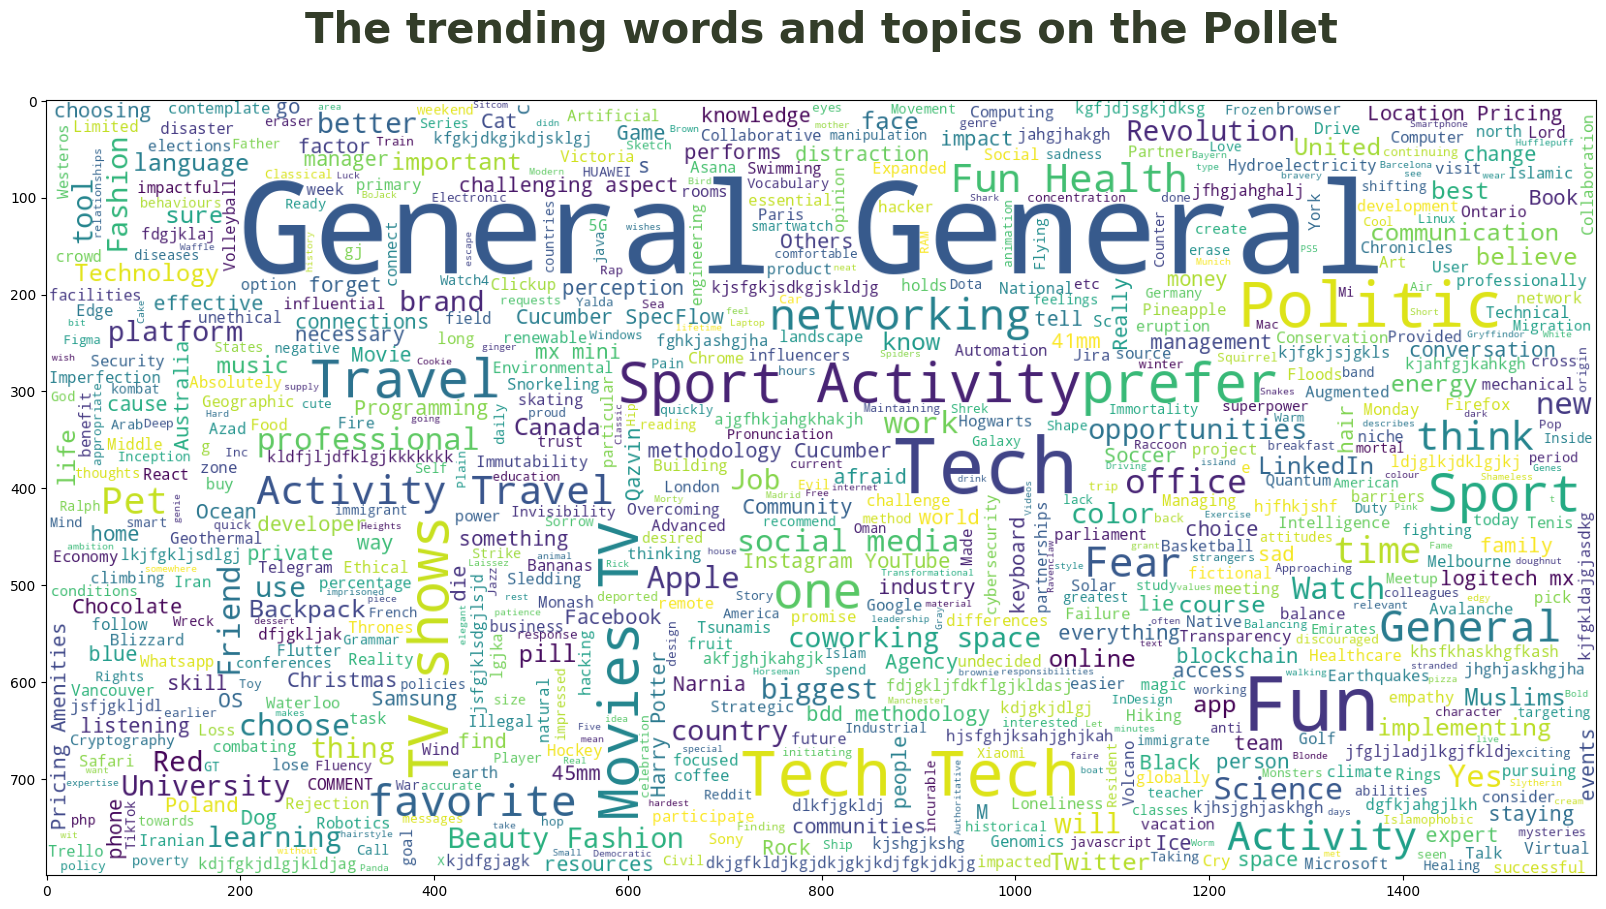

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


plt.figure(figsize=(20, 20))
plt.title(
    "The trending words and topics on the Pollet\n",
    fontsize=30,
    weight=600,
    color="#333d29",
)
wc = WordCloud(
    max_words=1000, min_font_size=10, height=800, width=1600, background_color="white"
).generate(" ".join(polls_df.apply(create_soup, axis=1)))

plt.imshow(wc)

In [14]:
cosine_similarity_matrix.shape

(96, 96)

In [12]:
user_exhibited_poll = [
    "f962ed50-91ef-463f-83e2-45b6a213228c",
    "611b1bf1-417d-4795-b3a5-f0817e890b1e",
    "5ac95383-3863-4004-9a69-3ec5c05a6d39",
    "8c10fe46-7eb7-43ce-bce0-684f5772af8f",
    "5f0d00a6-1e85-4458-83e3-14706337c475",
    "7cd8ef11-ff06-4dee-aa53-56afbc709c2f",
    "0a3bc11c-688a-4a91-8486-a81ee70176c5",
    "8daca63a-89a9-48da-933a-4970dad1b29d",
    "2790ca46-0065-49e8-ad29-ee6935dc73bb",
    "3cdbc91a-04f7-4b74-bbd1-19750622afe4",
    "1cac1483-b941-497f-be7e-4f26de64e2af",
]

from sklearn.metrics import average_precision_score
import numpy as np

# Sample data (replace this with your actual data)
# cosine_similarity_matrix = np.array([[0.8, 0.5, 0.2], [0.2, 0.7, 0.6], [0.4, 0.3, 0.9]])
# ground_truth = np.array([[1, 0, 1], [0, 1, 0], [1, 1, 0]])  # 1 indicates a relevant item


# Function to calculate AP for a single user
def calculate_ap(actual, predicted):
    return average_precision_score(actual, predicted)


# Calculate AP for each user
aps = [
    calculate_ap(ground_truth[i], cosine_similarity_matrix[i])
    for i in range(len(ground_truth))
]

# Calculate MAP
map_score = np.mean(aps)

# Print the results
print(f"Average Precision (AP) for each user: {aps}")
print(f"Mean Average Precision (MAP): {map_score}")

NameError: name 'ground_truth' is not defined